## Лабораторная работа 3. Линейные методы

Результат лабораторной работы − отчет в формате Jupyter notebook'а. Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: мне − меньше проверять, вам —  проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

### Оценивание и штрафы

* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов
* При сдаче до soft deadline можно получить максимум 100% баллов
* При просрочке не более, чем на 5 минут — максимум 90% баллов
* При просрочке не более, чем на 1 час — максимум 80% баллов
* При сдаче до hard deadline — максиму 70% баллов
* Сдавать задание после hard deadline нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

<a id='log_reg'></a>
## Логистическая регрессия

В этом пункте мы будем рассматривать бинарную классификацию, где метки классов лежат во множестве $\{-1, 1\}$. 

Задачу обучения регуляризованной логистической регрессии можно записать следующим образом:

$$ \dfrac{1}{N}\sum_{i=1}^N \log(1 + \exp(-y_i(\langle w, x_i \rangle + b))) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Обучение в данном случае сводится к нахождению вектора весов модели $w$ и константы $b$, которое производится с помощью метода градиентного спуска (Gradient Descent, GD). 

Градиентный шаг будет заключаться в обновлении вектора весов по следующей формуле:

$$w_{new} := w + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-y_i(\langle w, x_i \rangle + b))}\Big) - \eta Cw$$

$$b_{new} := b + \dfrac{\eta}{N}\sum_{i=1}^N y_i \Big(1 - \dfrac{1}{1 + exp(-y_i(\langle w, x_i \rangle + b))}\Big)$$

$$(w, b) := (w_{new}, b_{new})$$

где $\eta > 0$ — размер шага (learning rate).

В общем случае метод градиентного спуска имеет следующие недостатки:
- попадание в локальные минимумы
- неочевидность критерия останова
- выбор размера шага
- начальная инициализация весов

В этой части лабораторной работы мы предложим вам реализовать метод градиентного спуска, а также рассмотрим некоторые его модификации.



In [3]:
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline

### Задание

- Загрузите обучающий набор данных (X_train.csv, y_train.csv) из [набора данных конкурса 2](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2020).
- Для простоты в этом задании ограничимся работой с числовыми признаками (Numeric в таблице MetaData.csv).
- Заполните пропущенные значения в данных. Для этого могут пригодиться методы из sklearn.impute или pandas.DataFrame.fillna.
- Обратите внимание, что метки классов для данной задачи должны быть из множества {-1, 1}, а не {0, 1}.
- По желанию используйте любой препроцессинг данных, ваша задача — добиться сходимости и высокого качества полученной модели.

In [4]:
medical_data = [f'V{i}' for i in range(2, 332)]
gene_data = [f'V{i}' for i in range(332, 1332)]

In [5]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

X_test = pd.read_csv('data/X_test.csv')

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4099, 1330)
(4099, 1)
(1366, 1330)


In [7]:
X_train.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,826.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,0.5
1,15.0,0.0,0,0.0,0.0,0.0,0.0,0.030303,0.083333,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0
2,242.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,1.0,1.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.5
3,1038.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,971.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [8]:
X_test.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,685.0,0.0,0,0.0,0.0,0.0,0.0,0.010101,0.097222,0.0,...,0.5,0.5,0.5,0.0,0.5,0.5,0.5,0.0,0.0,0.0
1,1150.0,0.0,0,0.0,0.0,0.0,0.0,0.010101,0.083333,0.0,...,0.5,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5
2,91.0,0.0,1,0.0,0.0,0.0,1.0,0.010101,0.097222,0.0,...,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,332.0,0.0,1,0.0,0.0,0.0,1.0,NaN,NaN,0.0,...,0.5,0.5,0.5,0.0,0.5,0.0,0.0,NaN,0.0,0.0
4,714.0,0.0,1,0.0,0.0,1.0,1.0,NaN,NaN,NaN,...,0.5,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


In [9]:
y_train.head()

,label
0,0
1,0
2,0
3,0
4,0


In [10]:
meta_data = pd.read_csv('data/MetaData.csv')
meta_data.head()

,varnum,type,Column Type
0,V2,char,Numeric
1,V3,num,Category
2,V4,num,Category
3,V5,num,Category
4,V6,num,Category


In [11]:
numeric = meta_data[meta_data['Column Type'] == 'Numeric']['varnum'].values
numeric

array(['V2', 'V29', 'V31', 'V32', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V105', 'V111', 'V113', 'V114', 'V116', 'V118', 'V144',
       'V149', 'V152', 'V157', 'V158', 'V161', 'V162', 'V165', 'V170',
       'V175', 'V180', 'V186', 'V188', 'V189', 'V190', 'V191', 'V192',
       'V193', 'V195', 'V197', 'V198', 'V199', 'V201', 'V203', 'V204',
       'V205', 'V207', 'V208', 'V209', 'V235', 'V236', 'V237', 'V238',
       'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246',
       'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254',
       'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262',
       'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270',
       'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278',
       'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286',
       'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294',
       'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V302', 'V303',
       'V

In [12]:
len(numeric)

137

In [13]:
X_train = X_train[numeric]
X_test = X_test[numeric]

print(X_train.shape)
print(X_test.shape)

(4099, 137)
(1366, 137)


In [14]:
sum(X_train.isna().sum() > 0)

114

In [15]:
X_train.describe()

,V2,V29,V31,V32,V34,V35,V36,V37,V38,V39,...,V320,V321,V322,V323,V324,V325,V326,V327,V328,V331
count,4050.000000,4099.000000,4099.000000,4086.000000,4088.000000,4098.000000,4099.000000,4099.000000,4099.000000,4099.000000,...,4037.000000,4037.000000,4037.000000,4037.000000,4080.000000,4030.000000,4030.000000,4030.000000,4030.000000,4099.000000
mean,434.000988,0.418759,0.377803,0.068955,0.993885,0.887900,0.410042,0.357092,0.485781,0.322299,...,0.384444,0.610271,0.312917,0.204802,0.231904,0.622429,0.477875,0.522669,0.138306,0.520322
std,360.832558,0.104766,0.136818,0.228712,4.069883,0.109836,0.097301,0.138053,0.126246,0.121573,...,0.149358,0.180878,0.140969,0.150743,0.349645,0.060175,0.075524,0.059778,0.037003,0.233743
min,0.000000,0.079208,0.000000,0.000000,0.000000,0.000000,0.119048,0.016678,0.000000,0.007334,...,0.000000,0.000000,0.000176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,128.000000,0.346535,0.274725,0.000000,0.000000,0.846154,0.345238,0.260598,0.387399,0.236248,...,0.277590,0.518072,0.210218,0.076955,0.000000,0.593165,0.437247,0.492253,0.121195,0.300000
50%,331.000000,0.415842,0.373626,0.000000,0.000000,0.923077,0.404762,0.343989,0.486595,0.304960,...,0.367762,0.662651,0.307895,0.185221,0.000000,0.620144,0.471913,0.515495,0.133203,0.500000
75%,690.000000,0.485149,0.461538,0.000000,0.000000,0.961538,0.476190,0.434329,0.577748,0.386894,...,0.482393,0.746988,0.406215,0.297662,0.500000,0.652518,0.514676,0.544100,0.149679,0.700000
max,1361.000000,0.851485,0.934066,1.000000,49.000000,1.000000,0.839286,1.000000,0.922252,1.000000,...,1.000000,1.000000,1.000000,0.877818,1.000000,0.945683,1.000000,0.966627,1.000000,1.000000


### Data preprocessing

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [17]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)

X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
print(sum(y_train['label'] == 0))
print(sum(y_train['label'] == 0)/len(y_train))

3756
0.9163210539155892


In [20]:
y_train[y_train['label'] == 0] = -1
print(sum(y_train['label'] == -1))
print(sum(y_train['label'] == 1))

3756
343


In [21]:
y_train = y_train.values.flatten()
y_train

array([-1, -1, -1, ..., -1, -1, -1])

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4099, 137)
(4099,)
(1366, 137)


In [23]:
# save preprocessed data
pd.DataFrame(X_train).to_csv('x_train.csv', index=None)
pd.DataFrame(X_test).to_csv('x_test.csv', index=None)
pd.DataFrame(y_train).to_csv('y_train.csv', index=None)

**(4 балла)** Реализуйте градиентный спуск и протестируйте его для случая логистической регрессии на данных конкурса. Для сравнения качества разных подходов используйте значение оптимизируемого функционала.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4
 - ограничение на число итераций (например, 10000)
 
Для начальной инициализации весов нужно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученные результаты:
- Рассмотрите как влияет размер шага на сходимость (попробуйте не менее 5-ти различных значений).
- Рассмотрите регуляризованную модель (не менее 5-ти различных коэффициентов регуляризации), которая описана выше, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество (под качеством во всех случаях подразумевается значение исходного, нерегуляризованного функционала).
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

В каждом пункте требуется построить необходимые графики скорости/качества и дать исчерпывающие выводы.

In [26]:
def optimized_func(X, y, w, b):
    return np.mean(np.log(1.0 + np.exp(-y*(X.dot(w)+b))))

In [103]:
from sklearn.base import BaseEstimator, ClassifierMixin

class GDClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, is_stochastic=False, learning_rate=0.01, n_iter=10000, C=0.001, epsilon=1e-4,
                 random_init=False, random_state=42, check_iter=False):
        self.is_stochastic = is_stochastic
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.C = C
        self.epsilon = epsilon

        self.random_init = random_init
        self.random_state = random_state

        self.weights = None
        self.coeffs_ = None
        self.b = None

        self.res_iter = None
        self.check_iter = check_iter
        self.iter_score = None

    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    def compute_gradient(self, x, y, w):
        sigm = (1 - self.sigmoid(y * x.dot(w)))
        grad = np.dot(x.T, y * sigm)
        return grad if len(x.shape) == 1 else grad / len(x)

    def fit(self, X_train, y_train):
        X_tr, y = np.array(X_train), np.array(y_train)
        X_tr = np.c_[X_train, np.ones(len(y_train))]
        if y.ndim == 2:
            y = y.reshape((len(y),))

        x = X_tr
        n_obs = x.shape[0]
        n_features = x.shape[1]

        self.weights = np.zeros((2, n_features))

        if self.random_init:
            self.weights[1] = np.random.normal(size=(1, n_features))

        if self.check_iter:
            self.iter_score = []

        for k in range(self.n_iter - 1):
            if self.is_stochastic:
                ind = np.random.randint(0, n_obs - 1)
                x, y = X_tr[ind, :], y_train[ind]

            self.weights[0] = self.weights[1]
            w = self.weights[0]

            grad = self.compute_gradient(x, y, w) - w * self.C
            u = self.learning_rate * grad

            self.weights[1] = self.weights[0] + u
            self.weights[1][-1] += self.learning_rate * self.C * w[-1]

            if self.check_iter and not k % 100:
                print(k)
                score = optimized_func(X_train, y_train, self.weights[1][:n_features - 1], self.weights[1][-1])
                self.iter_score.append(score)

            if all(self.weights[1]) and np.linalg.norm(self.weights[0] - self.weights[1]) < self.epsilon:
                break

        self.coeffs_ = self.weights[1][:n_features - 1]
        self.b = self.weights[1][-1]
        self.res_iter = k + 1

        return self

In [51]:
from sklearn.model_selection import StratifiedKFold

def parameter_CV(X, y, par_name, grid, n_folds=5, random_init=False, add_par_name=None, add_par_value=None):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for par in grid[par_name]:
        cv_res = []
        print(f"{par_name} = {par}")
        kvals = {par_name: par}
        
        if add_par_name:
            kvals[add_par_name] = add_par_value
        
        if random_init:
            kvals['random_init'] = True
            
        for train_index, test_index in kf.split(X, y):
            X_tr, X_val = X[train_index], X[test_index]
            y_tr, y_val = y[train_index], y[test_index]

            clf = GDClassifier(**kvals)
            clf.fit(X_tr, y_tr)

            res = optimized_func(X_val, y_val, clf.coeffs_, clf.b)

            cv_res.append(res)
        results.append(np.mean(cv_res))
    return results

In [115]:
def iter_number(X, y, par_name, grid, random_init=False, n_iter=None, is_stochastic=None):
    results = []
    for par in grid[par_name]:
        print(f"{par_name} = {par}")
        kvals = {par_name: par}
        
        if n_iter:
            kvals['n_iter'] = n_iter
            
        if random_init:
            kvals['random_init'] = True
            
        if is_stochastic:
            kvals['is_stochastic'] = True
        
        clf = GDClassifier(**kvals)
        clf.fit(X, y)

        res = clf.res_iter
        results.append(res)
    return results

In [122]:
def plot_result(x, y, title="", xlabel="", ylabel="", xticks=None):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if not xticks is None:
        print(xticks)
        plt.xticks(x, xticks, rotation=90)
    
    plt.grid()

In [140]:
gd_grid = {
    'learning_rate': [1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1],
    'C': [0, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
}

### Zero initialization

In [141]:
lr_iter = iter_number(X_train, y_train, 'learning_rate', gd_grid, n_iter=15000)
lr_iter

learning_rate = 0.001
learning_rate = 0.01
learning_rate = 0.05
learning_rate = 0.1
learning_rate = 0.5
learning_rate = 1.0
learning_rate = 10.0


[7950, 4896, 4595, 4824, 2834, 14999, 14999]

[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]


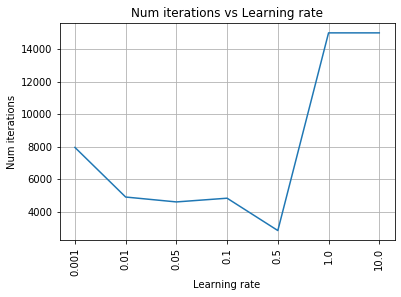

In [142]:
plot_result(range(len(lr_iter)), lr_iter, "Num iterations vs Learning rate", "Learning rate", "Num iterations", gd_grid["learning_rate"])
plt.show()

In [143]:
lr_res = parameter_CV(X_train, y_train, 'learning_rate', gd_grid)
lr_res

learning_rate = 0.001
learning_rate = 0.01
learning_rate = 0.05
learning_rate = 0.1
learning_rate = 0.5
learning_rate = 1.0
learning_rate = 10.0


[0.28873735780588367,
 0.24433446293738595,
 0.2506079334479486,
 0.2518109207075754,
 0.25264443516202656,
 0.2896866841897257,
 1.9342951929458607]

[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]


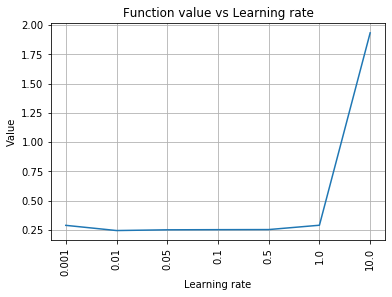

In [144]:
plot_result(range(len(lr_res)), lr_res, "Function value vs Learning rate", "Learning rate", "Value", gd_grid["learning_rate"])
plt.show()

In [145]:
C_res = parameter_CV(X_train, y_train, 'C', gd_grid)
C_res

C = 0
C = 0.0001
C = 0.001
C = 0.01
C = 0.1
C = 1.0
C = 10.0
C = 100.0


[0.24464210616909537,
 0.24460987664348616,
 0.24433446293738595,
 0.24242213279719144,
 0.23844023097279815,
 0.248119472378228,
 0.2750212178716798,
 0.2865816447945786]

[0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


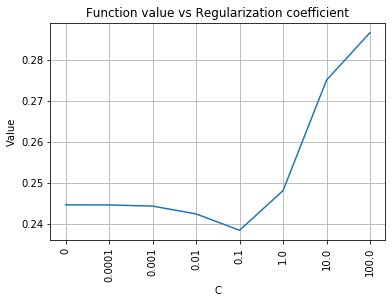

In [146]:
plot_result(range(len(C_res)), C_res, "Function value vs Regularization coefficient", "C", "Value", gd_grid["C"])
plt.show()

### Random initialization

In [147]:
lr_iter_rand = iter_number(X_train, y_train, 'learning_rate', gd_grid, n_iter=15000, random_init=True)
lr_iter_rand

learning_rate = 0.001
learning_rate = 0.01
learning_rate = 0.05
learning_rate = 0.1
learning_rate = 0.5
learning_rate = 1.0
learning_rate = 10.0


[14999, 14999, 14999, 11533, 6375, 14999, 14999]

[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]


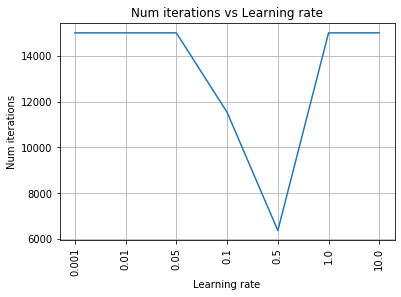

In [148]:
plot_result(range(len(lr_iter_rand)), lr_iter_rand, "Num iterations vs Learning rate", "Learning rate", "Num iterations", gd_grid["learning_rate"])
plt.show()

In [149]:
lr_res_rand = parameter_CV(X_train, y_train, 'learning_rate', gd_grid, random_init=True)
lr_res_rand

learning_rate = 0.001
learning_rate = 0.01
learning_rate = 0.05
learning_rate = 0.1
learning_rate = 0.5
learning_rate = 1.0
learning_rate = 10.0


[1.048639377587263,
 0.31105333934817647,
 0.2566072752107412,
 0.2533112576687101,
 0.2527464726395521,
 0.294706912319846,
 3.5432767021671174]

[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]


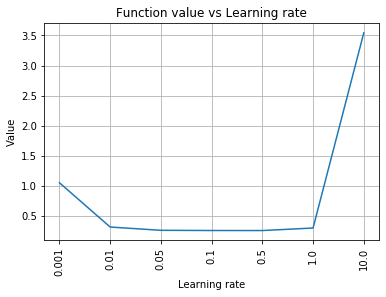

In [150]:
plot_result(range(len(lr_res_rand)), lr_res_rand, "Function value vs Learning rate", "Learning rate", "Value", gd_grid["learning_rate"])
plt.show()

In [151]:
C_res_rand = parameter_CV(X_train, y_train, 'C', gd_grid, random_init=True)
C_res_rand

C = 0
C = 0.0001
C = 0.001
C = 0.01
C = 0.1
C = 1.0
C = 10.0
C = 100.0


[0.3242799049770246,
 0.31786608067409106,
 0.2945266773873429,
 0.25241974684578017,
 0.23726365494264856,
 0.2481193234962861,
 0.2750211335654765,
 0.2865818231548044]

[0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


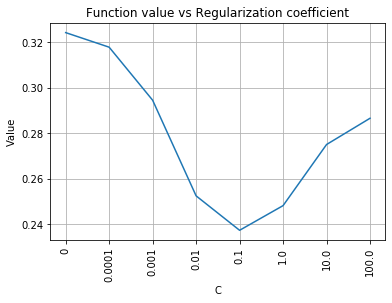

In [152]:
plot_result(range(len(C_res_rand)), C_res_rand, "Function value vs Regularization coefficient", "C", "Value", gd_grid["C"])
plt.show()

Теперь выберем новую сетку параметров, на которой посмотрим на значение функционала. Начальные значения весов будем задавать нулями, так как видно, что сходимость на рандомных весах не достигается при нашем фиксированном количестве итераций.
По значению параметра функционала видно, что 'learning_rate' лучше перебирать из промежутка [0.01, 0.1], а параметр 'C' - [0.05, 0.5]. Также еще раз проверим для случая без регуляризации.

In [79]:
gd_grid = {
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'C': np.linspace(0.05, 0.5, 5)
}

In [80]:
results = []
for c in gd_grid['C']:
    print(f'*** C={c} ***')
    results.append(parameter_CV(X_train, y_train, 'learning_rate', gd_grid, add_par_name='C', add_par_value=c))

*** C=0.05 ***
learning_rate = 0.01
learning_rate = 0.020000000000000004
learning_rate = 0.030000000000000006
learning_rate = 0.04000000000000001
learning_rate = 0.05000000000000001
learning_rate = 0.06000000000000001
learning_rate = 0.07
learning_rate = 0.08
learning_rate = 0.09000000000000001
learning_rate = 0.1
*** C=0.1625 ***
learning_rate = 0.01
learning_rate = 0.020000000000000004
learning_rate = 0.030000000000000006
learning_rate = 0.04000000000000001
learning_rate = 0.05000000000000001
learning_rate = 0.06000000000000001
learning_rate = 0.07
learning_rate = 0.08
learning_rate = 0.09000000000000001
learning_rate = 0.1
*** C=0.275 ***
learning_rate = 0.01
learning_rate = 0.020000000000000004
learning_rate = 0.030000000000000006
learning_rate = 0.04000000000000001
learning_rate = 0.05000000000000001
learning_rate = 0.06000000000000001
learning_rate = 0.07
learning_rate = 0.08
learning_rate = 0.09000000000000001
learning_rate = 0.1
*** C=0.3875 ***
learning_rate = 0.01
learning_ra

In [81]:
results.append(parameter_CV(X_train, y_train, 'learning_rate', gd_grid, add_par_name='C', add_par_value=0))

learning_rate = 0.01
learning_rate = 0.020000000000000004
learning_rate = 0.030000000000000006
learning_rate = 0.04000000000000001
learning_rate = 0.05000000000000001
learning_rate = 0.06000000000000001
learning_rate = 0.07
learning_rate = 0.08
learning_rate = 0.09000000000000001
learning_rate = 0.1


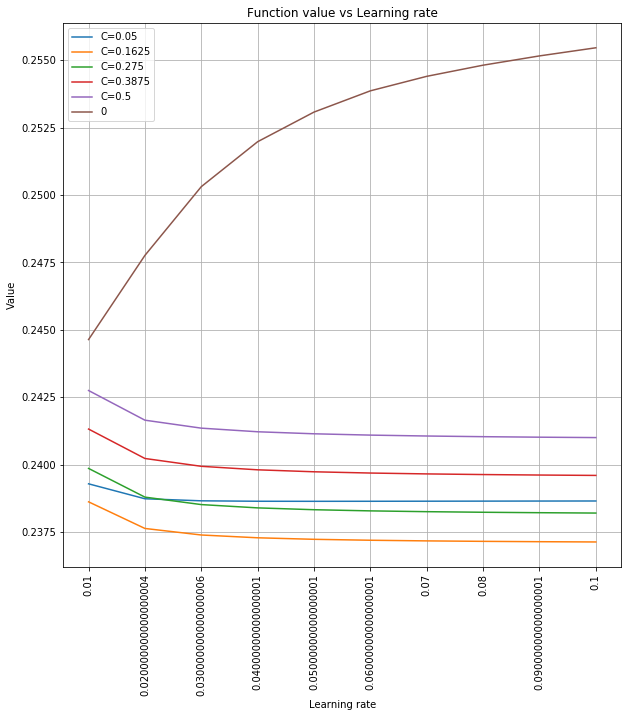

In [82]:
plt.figure(figsize=(10, 10))

plt.plot(range(10), results[0], label='C=0.05')
plt.plot(range(10), results[1], label='C=0.1625')
plt.plot(range(10), results[2], label='C=0.275')
plt.plot(range(10), results[3], label='C=0.3875')
plt.plot(range(10), results[4], label='C=0.5')
plt.plot(range(10), results[5], label='0')

plt.title("Function value vs Learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Value")
plt.xticks(range(10), gd_grid['learning_rate'], rotation=90)
plt.legend()

plt.grid()

Далее будем рассматривать следующие параметры классификатора: 'learning_rate' = 0.02, 'C' = 0.15.

### Plot value vs iteration

In [83]:
lr = 0.02
C = 0.15

In [69]:
clf = GDClassifier(learning_rate=lr, C=C, check_iter=True, n_iter=5000)
clf.fit(X_train, y_train)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


GDClassifier(C=0.15, check_iter=True, epsilon=0.0001, is_stochastic=False,
             learning_rate=0.02, n_iter=5000, random_init=False,
             random_state=42)

In [70]:
np.min(clf.iter_score)

0.22997200936248607

In [88]:
clf_rand = GDClassifier(learning_rate=lr, C=C, check_iter=True, n_iter=5000, random_init=True)
clf_rand.fit(X_train, y_train)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


GDClassifier(C=0.15, check_iter=True, epsilon=0.0001, is_stochastic=False,
             learning_rate=0.02, n_iter=5000, random_init=True,
             random_state=42)

In [89]:
np.min(clf_rand.iter_score)

0.2298177384163958

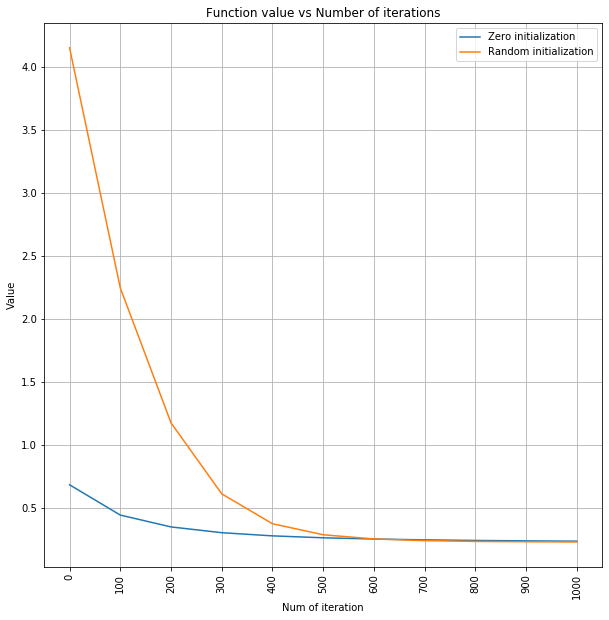

In [93]:
plt.figure(figsize=(10, 10))

plt.plot(range(11), clf.iter_score[:11], label='Zero initialization')
plt.plot(range(11), clf_rand.iter_score[:11], label='Random initialization')

plt.title("Function value vs Number of iterations")
plt.xlabel("Num of iteration")
plt.ylabel("Value")
plt.xticks(range(11), range(0, 1001, 100), rotation=90)
plt.legend()

plt.grid()

По количеству отработанных итераций видно, что для фиксированных значениях парметров 'learning_rate' и 'C' быстрее сходится метод с рандомным заданием весов. При этом из графика видно, что метод с нулевым заданием весов быстрее оказывается возле итогового значения оптимизируемого функционала.

Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту. 

**(1.5 балла)** Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов. Реализуйте метод в виде класса, удовлетворяющего интерфейсу scikit-learn ([тут есть пример](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/)).

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

- Посмотрите как влияет размер шага на сходимость (попробуйте 4-5 различных значений)
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации

Выберите лучший размер шага и сравните качество и скорость сходимости реализованного метода и [его аналога из scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (не забудьте выставить значения важных параметров tol и learning_rate для сравнения методов в приближённо равных условиях). Насколько получилось лучше/хуже, в чём могут быть причины?

В каждом пункте сделайте исчерпывающие выводы, подкреплённые графиками.

### SGD

Класс был реализован выше. Введен параметр 'is_stochastic' для того, чтобы можно было использовать оба метода.

Будем использовать следующие параметры для классификатора: 'learning_rate' = 0.02, 'C' = 0.15, 'random_init'=False, 'is_stochastic'=True. 

In [106]:
clf_sgd = GDClassifier(learning_rate=lr, C=C, n_iter=10000, is_stochastic=True, check_iter=True)
clf_sgd.fit(X_train, y_train)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


GDClassifier(C=0.15, check_iter=True, epsilon=0.0001, is_stochastic=True,
             learning_rate=0.02, n_iter=10000, random_init=False,
             random_state=42)

In [107]:
np.min(clf_sgd.iter_score)

0.2449315301986097

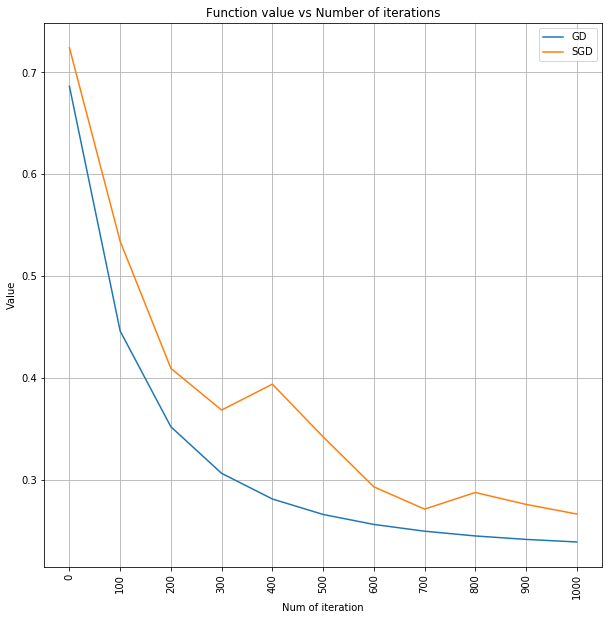

In [108]:
plt.figure(figsize=(10, 10))

plt.plot(range(11), clf.iter_score[:11], label='GD')
plt.plot(range(11), clf_sgd.iter_score[:11], label='SGD')

plt.title("Function value vs Number of iterations")
plt.xlabel("Num of iteration")
plt.ylabel("Value")
plt.xticks(range(11), range(0, 1001, 100), rotation=90)
plt.legend()

plt.grid()

Уже видно, что стохастическому градиентному спуску требуется больше итераций, чтобы сойтись. Это вызвано тем, что мы пересчитываем градиент только по одной переменной, а не по всем сразу. Также из графика видно, что качество стохастического градиентного спуска скачет с итерациями.

In [109]:
sgd_grid = {
    'learning_rate': 
}

In [153]:
results = []
for lr in np.linspace(0.001, 1, 10):
    clf = GDClassifier(learning_rate=lr, C=C, n_iter=100000)
    clf.fit(X_train, y_train)

    res = clf.res_iter
    results.append(res)

In [154]:
results_0 = []
for lr in np.linspace(0.001, 1, 10):
    clf = GDClassifier(learning_rate=lr, C=0, n_iter=100000)
    clf.fit(X_train, y_train)

    res = clf.res_iter
    results_0.append(res)

In [156]:
print(results)
print(results_0)

[7749, 790, 464, 335, 262, 206, 99999, 99999, 99999, 99999]
[7952, 11192, 14557, 14285, 13465, 12620, 11854, 99999, 99999, 99999]


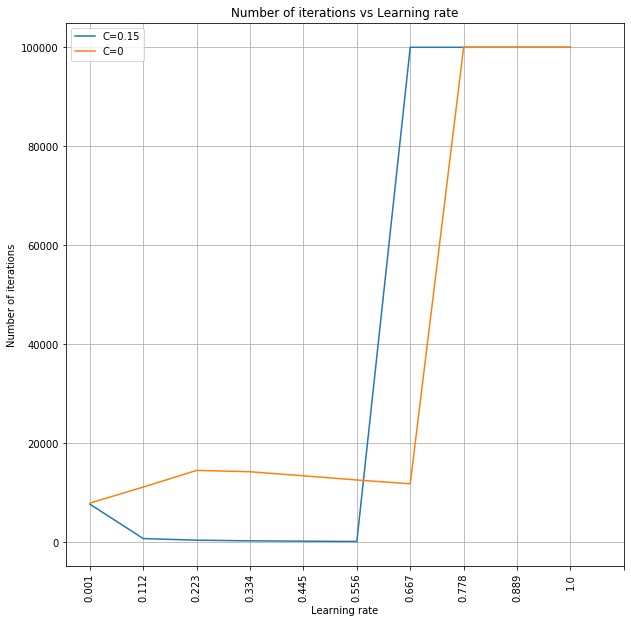

In [155]:
plt.figure(figsize=(10, 10))

plt.plot(range(10), results, label=f'C={C}')
plt.plot(range(10), results_0, label='C=0')

plt.title("Number of iterations vs Learning rate")
plt.ylabel("Number of iterations")
plt.xlabel("Learning rate")
plt.xticks(range(11), np.linspace(0.001, 1, 10), rotation=90)
plt.legend()

plt.grid()

Видно, что с какого-то момента значение шага становится таким, что метод не может попасть в глобальный минимум и выскакивает и ему требуется достаточно большое количество итераций, чтобы сойтись.

Между обновлением вектора весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окрестности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{\theta}{J(\theta)}$$
$$ \theta = \theta - v_t$$

где

 - $\theta$ — вектор параметров (в нашем случае — $w$)
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное отличие данного метода от SGD состоит в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $\theta_i$ на итерации $t$ как $g_{t,i} = \nabla_{\theta}J(\theta_i)$. 

В случае sgd обновление параметра $\theta_i$ будет выглядеть следующим образом:

$$ \theta_{t+1, i} = \theta_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ \theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $\theta_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична гиперпараметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 
$$\Delta \theta_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $\theta$:

$$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma)\Delta \theta^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta \theta_t = - \dfrac{RMS[\Delta \theta^2]}{RMS[ga^2]} g_t $$ 
$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - статья про [momentum](https://pdfs.semanticscholar.org/97da/c94ffd7a7ac09a4218848300cc7e98569d77.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) разных способов оптимизации

### Задание

Реализуйте метод оптимизации *Momentum* **(1 балл)** и один из *Adagrad*/*Adadelta* **(1.5 балла)**.
- Сравните оба метода с классическим sgd с точки зрения скорости сходимости.
- Посмотрите как значение гиперпараметра $\gamma$ влияет на скорость сходимости и качество в методе *Momentum*.

В заданиях выше требуется построить графики и описать полученные результаты.

Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

### Momentum

In [228]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MomentumSGDClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, gamma=0.9, n_iter=10000, C=0.001, epsilon=1e-4, check_iter=False):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.C = C
        self.epsilon = epsilon
        self.gamma = gamma
        
        self.weights = None
        self.coeffs_ = None
        self.b = None
        self.res_iter = None
        
        self.check_iter = check_iter
        self.iter_score = None

    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    def compute_gradient(self, x, y, w):
        sigm = (self.sigmoid(y * x.dot(w)) - 1)
        grad = np.dot(x.T, y * sigm)
        return grad if len(x.shape) == 1 else grad / len(x)
    
    def fit(self, X_train, y_train):
        X_tr, y = np.array(X_train), np.array(y_train)
        X_tr = np.c_[X_train, np.ones(len(y_train))]
        if y.ndim == 2:
            y = y.reshape((len(y),))

        x = X_tr
        n_obs = x.shape[0]
        n_features = x.shape[1]

        self.weights = np.zeros((2, n_features))

        if self.check_iter:
            self.iter_score = []
        
        v = np.zeros((1, n_features))

        for k in range(self.n_iter - 1):
            ind = np.random.randint(0, n_obs - 1)
            x, y = X_tr[ind, :], y_train[ind]

            self.weights[0] = self.weights[1]
            w = self.weights[0]

            grad = self.compute_gradient(x, y, w) + w * self.C
            grad[-1] -= w[-1]*self.C 
            v = self.gamma * v - (1-self.gamma)*self.learning_rate * grad

            self.weights[1] = self.weights[0] + v

            if self.check_iter and not k % 100:
                print(k)
                score = optimized_func(X_train, y_train, self.weights[1][:n_features - 1], self.weights[1][-1])
                self.iter_score.append(score)

            if all(self.weights[1]) and np.linalg.norm(self.weights[0] - self.weights[1]) < self.epsilon:
                break

        self.coeffs_ = self.weights[1][:n_features - 1]
        self.b = self.weights[1][-1]
        self.res_iter = k + 1

        return self

In [207]:
clf_sgd = GDClassifier(n_iter=100000, is_stochastic=True, check_iter=True)
clf_sgd.fit(X_train, y_train)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


GDClassifier(C=0.001, check_iter=True, epsilon=0.0001, is_stochastic=True,
             learning_rate=0.01, n_iter=100000, random_init=False,
             random_state=42)

In [229]:
clf_mom = MomentumSGDClassifier(n_iter=10000, check_iter=True)
clf_mom.fit(X_train, y_train)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


MomentumSGDClassifier(C=0.001, check_iter=True, epsilon=0.0001, gamma=0.9,
                      learning_rate=0.01, n_iter=10000)

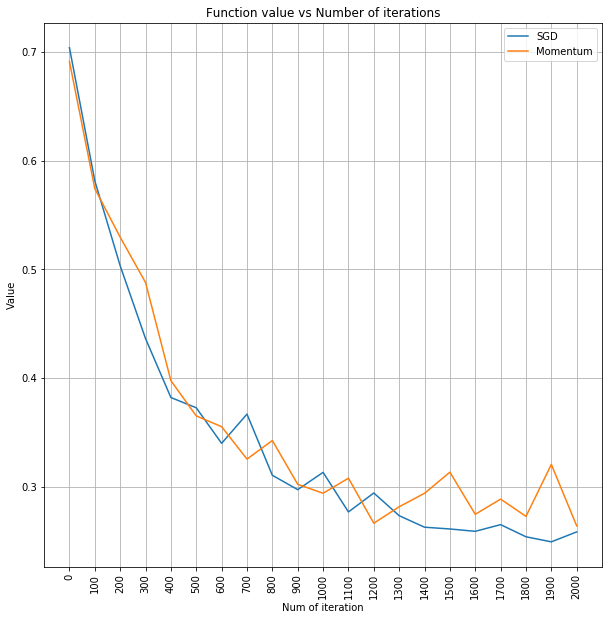

In [230]:
plt.figure(figsize=(10, 10))

plt.plot(range(21), clf_sgd.iter_score[:21], label='SGD')
plt.plot(range(21), clf_mom.iter_score[:21], label='Momentum')

plt.title("Function value vs Number of iterations")
plt.xlabel("Num of iteration")
plt.ylabel("Value")
plt.xticks(range(21), range(0, 2001, 100), rotation=90)
plt.legend()

plt.grid()

Видим, что оба метода дают эквивалентную сходимость. Причем по количеству итераций СГС оказался даже быстрее.

In [235]:
results = []
for par in np.linspace(0.5, 0.95, 10):
    print(f"gamma = {par}")
    
    clf = MomentumSGDClassifier(gamma=par, n_iter=1000000)
    clf.fit(X_train, y_train)

    res = clf.res_iter
    results.append(res)

gamma = 0.5
gamma = 0.55
gamma = 0.6
gamma = 0.65
gamma = 0.7
gamma = 0.75
gamma = 0.8
gamma = 0.85
gamma = 0.8999999999999999
gamma = 0.95


[0.75       0.77222222 0.79444444 0.81666667 0.83888889 0.86111111
 0.88333333 0.90555556 0.92777778 0.95      ]


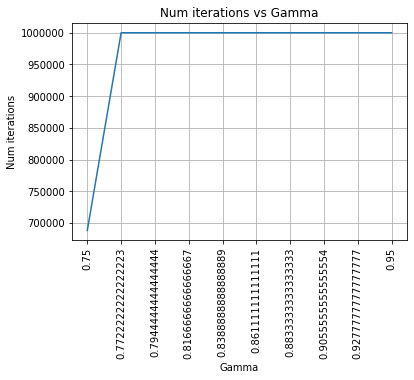

In [236]:
plot_result(range(len(results)), results, "Num iterations vs Gamma", "Gamma", "Num iterations", np.linspace(0.75, 0.95, 10))
plt.show()

Видно, что параметр гамма не сильно влияет на скорость сходимости метода.

В результате выполнения заданий выше вы получите базовое решение для [конкурса](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2020).

### Многоклассовая классификация

Модель логистической регрессии можно обобщить для случая многоклассовой классификации. Метка класса теперь лежит во множестве $\{1, 2, ..., K\}$. Параметры модели $w$ в этом случае являются матрицей размерности $K \times M$, где $M$ − количество признаков. Обучение модели логистической регрессии в многоклассовом случае будет выглядеть следующим образом:

$$ -\dfrac{1}{N}\sum_{i=1}^N \sum_{k=1}^K [y_i = k] \log\Big(\frac{\exp(\langle w_k, x_i \rangle)}{\sum_{s=1}^K \exp(\langle w_s, x_i \rangle))}\Big) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Здесь $w_k$ обозначает $k$-ую строку матрицы $w$.

Обучать эту модель также можно с помощью градиентного спуска.

Кроме того существует другой, более универсальный способ решать задачу многоклассовой классификации. Для этого нужно обучить несколько бинарных моделей классификации, после чего на основании предсказаний по этим моделям вынести окончательный вердикт о принадлежности объекта одному из $K$ классов. Существует две популярные стратегии использования бинарных классификаторов для задачи многоклассовой классификации:
 - OvR (One-vs-Rest, One-vs-All) − стратегия, при которой каждый из $K$ классификаторов обучается отделять объекты одного класса от объектов всех остальных классов. В качестве предсказания используется тот класс, классификатор которого предсказал наибольшую вероятность среди всех.
 - OvO (One-vs-One) − стратегия, при которой каждый из $\frac{K(K-1)}{2}$ классификаторов учится разделять объекты пары классов, игнорируя объекты всех остальных классов. На этапе предсказания класс обычно выбирается путем голосования по вердиктам каждого из классификаторов.


### Задание

**(1.5 балла)** 
Сгенерируйте несколько выборок точек с 2 признаками и 3 классами (по 100 объектов каждого класса) на которых будете проводить эксперименты. Для этого можно воспользоваться функцией [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) из пакета sklearn.

Обучите [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета sklearn тремя различными способами:
 - в режиме multinomial, оптимизирующем многоклассовую функцию потерь
 - в режиме OvR
 - в режиме OvO
 
Первые два способа реализованы в самом классе LogisticRegression, в то время как для решения задачи третьим методом в sklearn реализован класс [OneVsOneClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html) (класс для OvR схемы [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html), конечно, также присутствует в пакете).
 
 
 Проделайте следующие шаги для каждой стратегии и прокомментируйте полученные результаты:
 - Изобразите точки выборки, а также разделяющие прямые (их должно быть по 3 для каждой из стратегий). Проведите эксперимент на всех сгенерированных выборках.
 - Какие особенности, преимущества и недостатки с точки зрения построения разделяющих плоскостей, качества разделения классов и вычислительной эффективности характерны для каждого метода? Дайте развёрнутый ответ.
 - Для каждой из стратегий приведите примеры ситуаций, когда стоит выбирать ее для решения задачи многоклассовой классификации. Обоснуйте


## Линейная регрессия

Метод градиентного спуска позволяет оптимизировать произвольные функции. Например, рассмотрим задачу линейной регрессии, где $y \in \mathbb{R}$, а алгоритм будет иметь вид $a(x) = \langle w, x\rangle$. В случае метода наименьших квадратов оптимизируемый функционал можно записать следующим образом:

$$ \sum_{i=1}^N (\langle w, x_i \rangle - y_i) ^ 2 \to \min_w$$

Эта задача интересна тем, что для нее можно выписать аналитическое решение. Попробуем сравнить эти подходы.

### Задание

Сгенерируйте выборку из 600 точек с двумя признаками для задачи регрессии, воспользовавшись функцией [make_regression](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression). 

**(0.5 балла)** Выпишите как выглядит точное решение задачи линейной регрессии. Решите задачу регрессии с помощью этого подхода без использования и с использованием регуляризации. Есть ли недостатки у такого подхода к решению задачи?

**(0.5 балла)** Примените метод стохастического градиентного спуска реализованный ранее. Сильно ли отличается полученный вектор параметров по сравнению с точным решением? 

К сожалению, линейная регрессия позволяет хорошо восстанавливать *линейные* зависимости, однако в общем случае хуже работает с более сложными данными. Это хорошо можно увидеть на следующем примере.

Пусть исходная зависимость имеет вид $y = x \cdot sin(x)$. Сгенерируем соответствующие точки:

In [216]:
from sklearn.cross_validation import train_test_split

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [ ]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')

Если теперь к полученным данным применить модель линейной регрессии, то получим следующее решение:

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train[:, np.newaxis], y_train)

In [ ]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr.predict(X[:, np.newaxis])
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Качество модели регрессии можно оценивать с помощью некоторых метрик, например $MSE = \sum_{i=1}^l(a(x_i) - y_i)^2$ и в данном случае оно равно:

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, lr.predict(X_test[:, np.newaxis])) 

Построенное решение совсем отдаленно напоминает исходную зависимость. Одним из способов улучшить результат является добавление всех попарных произведений признаков, а также степеней: $x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2, \dots$

### Задание

**(0.5 балла)** Воспользуйтесь классом [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) и добавьте к данным зависимости $y = x \cdot sin(x)$ различные полиномы.

 - рассмотрите как степень полинома (от 1 до 20) влияет на качество
 - изобразите на графике предсказание аналогично линейной регрессии
 - сравните этот подход с функцией [polyfit](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html)

В чем могут быть недостатки такого подхода?

## Линейный SVM

Вернемся к задаче бинарной классификации. Будем обозначать обучающую выборку $\{(x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

SVM обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям, называются _опорными_.

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели. Этот гиперпараметр отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соответствующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального гиперпараметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

Особенность этого метода в том, что он имеет решение, которое может быть найдено используя квадратичное программирование. В этом задании мы не будем сводить данную задачу к задаче квадратичного программирования, а воспользуемся готовой реализацией из библиотеки sklearn.

### Особенности реализации

Обратите внимание, что в библиотеке sklearn можно найти 2 реализации линейного SVM: [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) и [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с ядровой функцией *linear*. Эти реализации имеют различие в библиотеках, на которых основаны: в первом случае используется библиотека *liblinear*, во втором — *libsvm*. Каждая из библиотек имеет свои плюсы, поэтому перед применением стоит определиться какая из реализаций подходит больше. Обратите внимание, что это различие есть только для линейного SVM.

В данном задании рекомендуем использовать класс [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с параметром *kernel='linear'*.

### Задание

Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно-разделимыми классами
- с хорошо разделимыми классами, но не линейно
- с плохо разделимыми классами по имеющимся признакам
    
Для генерации случайной выборки можно воспользоваться функциями, которые находятся в пакете [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). Для того чтобы выборки не менялись при перезапуске ноутбука, фиксируйте параметр *random_state*.

**(1 балл)** Протестируйте линейный SVM  на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Проделайте это для разных значений параметра $C$ (не менее 4-х).
Как зависит число опорных векторов от параметра $C$ для различных выборок?

#### Явное преобразование признаков

Как и в случае с линейной регрессией, когда оптимальная разделяющая гиперплоскость не является линейной, данная модель является очень грубым решением. Линейная неразделимость объектов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, аналогичное добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

## Двойственный переход и Ядровой SVM

![](http://i.imgur.com/bJAzRCt.png)

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](http://www.machinelearning.ru/wiki/images/2/25/SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 


В этом задании используйте класс $sklearn.svm.SVC$, меняя тип ядра. 

### Задание

**(1 балл)** Протестируйте на предыдущих двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
- линейная: $k(x, x') = x^Tx'$
- полиномиальная: $k(x, x') = (x^Tx' + 1)^d$ с различными степенями $d = 2,3,\dots$
- Гауссовская-RBF: $k(x, x') = \exp(-\sigma\|x - x'\|^2)$

Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $d$?
 - Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\sigma$? Поварьируйте параметры $C$ и $\sigma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

## Выводы

**(2 балла)** В этой работе вы рассмотрели некоторые линейные модели машинного обучения, а также способы их обучения. Ответьте на следующие вопросы:

 - Какие есть достоинства у рассмотренных моделей? Поясните свой ответ для каждой модели.
 - Каким общим недостатком обладают данные модели? Какие есть способы его устранения? В чем может заключаться сложность использования этого подхода?
 - В чем заключаются различия с точки зрения обучения алгоритмов? Какие есть достоинства и недостатки у рассмотренных методов обучения?
 - Предположите в каком случае каждый из алгоритмов будет работать лучше: при большом/небольшом количестве данных? Поясните почему. 